# Prepare The Jsonl and Image Dataset 

In [1]:
# Delete output folders in kaggle if u have any
import shutil
shutil.rmtree('/kaggle/working', ignore_errors=True)

# Install Libraries

In [5]:
%%capture
!pip install -q -U keras-nlp
!pip install -q -U keras>=3
!pip install einops

In [4]:
!pip install -q -U keras keras-hub

import os
# Set the backbend before importing Keras
os.environ["KERAS_BACKEND"] = "jax"
# Avoid memory fragmentation on JAX backend.
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.00"

TRAIN_EXAMPLES = 4
LEARNING_RATE = 0.003
BATCH_SIZE =1 

TRAIN_STEPS = TRAIN_EXAMPLES // BATCH_SIZE
EVAL_STEPS = TRAIN_STEPS // 4
print("TRAIN_STEPS", TRAIN_STEPS, "EVAL_STEPS", EVAL_STEPS)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 704.8/704.8 kB 35.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
keras-nlp 0.18.1 requires keras-hub==0.18.1, but you have keras-hub 0.19.1 which is incompatible.
tensorflow-decision-forests 1.10.0 requires tensorflow==2.17.0, but you have tensorflow 2.17.1 which is incompatible.
TRAIN_STEPS 4 EVAL_STEPS 1


# Training and Validation Dataset

In [6]:
import os
import json
import numpy as np
import tensorflow as tf
from PIL import Image
import io
import base64
import html
import numpy as np
import keras
import keras_hub
import tensorflow as tf
import matplotlib.pyplot as plt

from IPython.core.display import display, HTML

# Paths to JSONL files and image folders
train_jsonl_path = "/kaggle/input/image-captioning-dataset/Image Data/data_train90.jsonl"
val_jsonl_path = "/kaggle/input/image-captioning-dataset/Image Data/data_val10.jsonl"
train_image_folder = "/kaggle/input/image-captioning-dataset/Image Data/train_data"  # Folder containing training images
val_image_folder = "/kaggle/input/image-captioning-dataset/Image Data/val_data"  # Folder containing validation images

# Image size
target_size = (224, 224) # with respect to pali gemma

# Function to load and preprocess an image
def load_image(image_path):
    image = Image.open(image_path) 
    image = image.resize(target_size)
    image = np.array(image, dtype=np.float32) # Do not Normalize it Pali gemma only accepts tensors with no normalization
    return tf.convert_to_tensor(image)  # Convert NumPy array to TensorFlow tensor


captions = []
images = []
# Function to load dataset from JSONL and corresponding image folder
def load_dataset(jsonl_path, image_folder):
    with open(jsonl_path, "r") as f:
        for line in f:
            sample = json.loads(line)
            captions.append(sample["suffix"])
            image_name = sample["image"]
            image_path = os.path.join(image_folder, image_name)
            # print(image_path,load_image(image_path))
            # Ensure image exists before loading
            if os.path.exists(image_path):
                images.append(load_image(image_path)) # converting image into tensors 
        # print(len(images), len(captions))
        # print(images)
        # print(captions)
    # Convert to TensorFlow dataset
    return tf.data.Dataset.from_tensor_slices({
        "images": images,
        "prompts": ["caption en\n"] * len(images),
        "responses": captions,
    }).shuffle(1000).batch(BATCH_SIZE)

# # Load train and validation datasets
train_data = load_dataset(train_jsonl_path, train_image_folder)
val_data = load_dataset(val_jsonl_path, val_image_folder)

print("Train and validation datasets created successfully.")


Train and validation datasets created successfully.


In [7]:
captions[0]

"A brown and white cat with a red collar looks to the left, its eyes shining yellow. The cat's fur is long and silky, and its whiskers are long and prominent. The cat's nose is pink, and its ears are pointy. The cat's eyes are yellow, and its fur is brown and white. The cat is standing in the dark, and its head is turned to the side."

In [8]:
images[0]

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[ 5., 21., 21.],
        [ 5., 21., 21.],
        [ 5., 21., 21.],
        ...,
        [ 5., 21., 20.],
        [ 5., 21., 20.],
        [ 5., 21., 20.]],

       [[ 5., 21., 21.],
        [ 5., 21., 21.],
        [ 5., 21., 21.],
        ...,
        [ 5., 21., 20.],
        [ 5., 21., 20.],
        [ 5., 21., 20.]],

       [[ 5., 21., 21.],
        [ 5., 21., 21.],
        [ 5., 21., 21.],
        ...,
        [ 6., 22., 21.],
        [ 5., 21., 20.],
        [ 5., 21., 20.]],

       ...,

       [[ 2., 18., 18.],
        [ 2., 18., 18.],
        [ 2., 18., 18.],
        ...,
        [32., 39., 38.],
        [19., 28., 26.],
        [20., 28., 26.]],

       [[ 2., 18., 18.],
        [ 2., 18., 18.],
        [ 2., 18., 18.],
        ...,
        [24., 31., 31.],
        [24., 30., 28.],
        [21., 27., 25.]],

       [[ 2., 18., 18.],
        [ 2., 18., 18.],
        [ 2., 18., 18.],
        ...,
        [25., 34., 

In [9]:
print(val_data)
print(train_data)

<_BatchDataset element_spec={'images': TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), 'prompts': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'responses': TensorSpec(shape=(None,), dtype=tf.string, name=None)}>
<_BatchDataset element_spec={'images': TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), 'prompts': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'responses': TensorSpec(shape=(None,), dtype=tf.string, name=None)}>


In [10]:
for sample in train_data.take(1):  # Take one batch
    print(sample["images"].shape)  # Shape of images
    print(sample["prompts"])  # Prompts
    print(sample["responses"])  # Captions/labels


(1, 224, 224, 3)
tf.Tensor([b'caption en\n'], shape=(1,), dtype=string)
tf.Tensor([b"A lily pad and a lily pad flower float effortlessly on the ripples, while a brown leaf and a brown lily pad provide a contrast to the white flower. The lily pad flower's yellow center and orange center add a splash of color to the water's surface. The water reflects the flower's beauty, creating a serene and tranquil atmosphere."], shape=(1,), dtype=string)


# View Dataset

Training examples



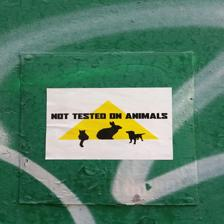
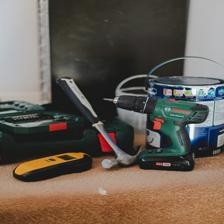
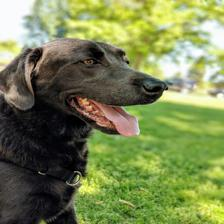
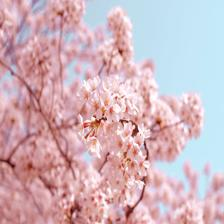
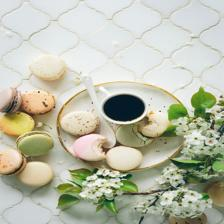
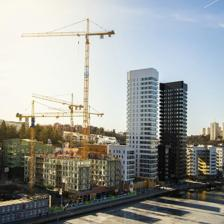
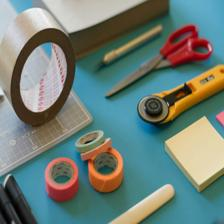
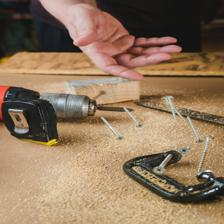

In [11]:
def render_inline(image, resize=(224, 224)):
  """Convert image into inline html."""
  image = tf.keras.preprocessing.image.array_to_img(image)
  image.resize(resize)
  with io.BytesIO() as buffer:
    image.save(buffer, format='jpeg')
    image_b64 = str(base64.b64encode(buffer.getvalue()), "utf-8")
    return f"data:image/jpeg;base64,{image_b64}"

def render_example(image, caption):
  image = np.asarray(image)
  return f"""
    <div style="display: inline-flex; align-items: center; justify-content: center;">
        <img style="width:128px; height:128px;" src="{render_inline(image, resize=(64,64))}" />
        <p style="width:256px; margin:10px; font-size:small;">{html.escape(caption)}</p>
    </div>
    """

html_out = ""

for element in train_data.take(8):
  caption = tf.compat.as_str_any(element["responses"].numpy()[0])
  html_out += render_example(element["images"].numpy()[0], caption)

print("Training examples")
display(HTML(html_out))

# Load Model

In [12]:
pali_gemma_lm = keras_hub.models.PaliGemmaCausalLM.from_preset(
    "/kaggle/input/paligemma/keras/pali_gemma_3b_224/4"
)
pali_gemma_lm.summary()

Preprocessor: "pali_gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ pali_gemma_tokenizer (PaliGemmaTokenizer)                     │                      Vocab size: 257,152 │
├───────────────────────────────────────────────────────────────┼──────────────────────────────────────────┤
│ pali_gemma_image_converter (PaliGemmaImageConverter)          │                   Image size: (224, 224) │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "pali_gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ images (InputLayer)           │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ response_mask (InputLayer)    │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pali_gemma_backbone           │ (None, None, 2048)        │   2,923,335,408 │ images[0][0],              │
│ (PaliGemmaBackbone)           │                           │                 │ padding_mask[0][0],        │
│                               │                           │                 │ response_mask[0][0],       │
│                               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 257152)      │     526,647,296 │ pali_gemma_backbone[0][0]  │
│ (ReversibleEmbedding)         │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item (GetItem)            │ (None, None, 257152)      │               0 │ token_embedding[1][0]      │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,923,335,408 (10.89 GB)

 Trainable params: 2,923,335,408 (10.89 GB)

 Non-trainable params: 0 (0.00 B)

## Inference before fine tuning


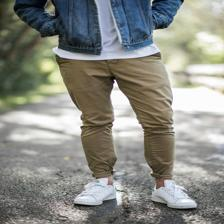


Inference Result



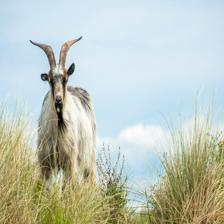
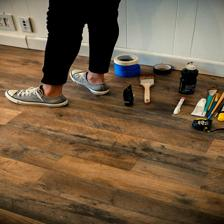
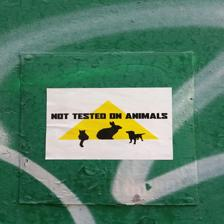
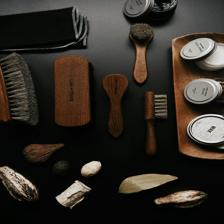

In [13]:
test_image_url = "/kaggle/input/image-captioning-dataset/Image Data/val_data/100.jpeg"
test_image = load_image(test_image_url)

def inference_test(image): # loaded image should always be in tensors
  prompt = 'caption en\n'
  output = pali_gemma_lm.generate(
      inputs={
          "images": image,
          "prompts": prompt,
      }
  )
  return render_example(image, output)

display(HTML(inference_test(test_image)))


def make_predictions():
  html_out = ""
  for element in val_data.take(4):
    html_out += inference_test(element["images"].numpy()[0])

  print("\nInference Result")
  display(HTML(html_out))

make_predictions()

# Implementing Lora

In [14]:
# Enable lora to freeze most of the model and save memory.
pali_gemma_lm.backbone.enable_lora(4)
pali_gemma_lm.summary()

# Lower our sequence length to further save memory.
pali_gemma_lm.preprocessor.sequence_length = 64

# Use Cosine Decay Scheduler with Warm up
#cosine_decay_scheduler = tf.keras.optimizers.schedules.CosineDecay(
#    initial_learning_rate = 0,
#    decay_steps = TRAIN_EXAMPLES,
#    warmup_target = LEARNING_RATE,
#    warmup_steps = TRAIN_EXAMPLES / 10
#)

def plot_scheduler(step, scheduler):
  x = range(step)
  y = []
  for step in x:
    y.append(scheduler(step))
  plt.plot(x, y, label=scheduler.name)
  plt.xlabel('Epoch')
  plt.ylabel('Learning Rate')
  plt.legend()
  plt.show()

#plot_scheduler(TRAIN_EXAMPLES, cosine_decay_scheduler)

# Use AdamW (a common optimizer for transformer models).
#optimizer = keras.optimizers.SGD(learning_rate=cosine_decay_scheduler)
optimizer = keras.optimizers.AdamW(learning_rate=LEARNING_RATE)

pali_gemma_lm.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

Preprocessor: "pali_gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ pali_gemma_tokenizer (PaliGemmaTokenizer)                     │                      Vocab size: 257,152 │
├───────────────────────────────────────────────────────────────┼──────────────────────────────────────────┤
│ pali_gemma_image_converter (PaliGemmaImageConverter)          │                   Image size: (224, 224) │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "pali_gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ images (InputLayer)           │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ response_mask (InputLayer)    │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pali_gemma_backbone           │ (None, None, 2048)        │   2,925,197,040 │ images[0][0],              │
│ (PaliGemmaBackbone)           │                           │                 │ padding_mask[0][0],        │
│                               │                           │                 │ response_mask[0][0],       │
│                               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 257152)      │     526,647,296 │ pali_gemma_backbone[0][0]  │
│ (ReversibleEmbedding)         │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item (GetItem)            │ (None, None, 257152)      │               0 │ token_embedding[1][0]      │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,925,197,040 (10.90 GB)

 Trainable params: 1,923,840 (7.34 MB)

 Non-trainable params: 2,923,273,200 (10.89 GB)

# Fine Tune the Model


Epoch 1/4
90/90 ━━━━━━━━━━━━━━━━━━━━ 118s 868ms/step - loss: 1.6867 - sparse_categorical_accuracy: 0.5477
Epoch 2/4
90/90 ━━━━━━━━━━━━━━━━━━━━ 79s 547ms/step - loss: 1.0062 - sparse_categorical_accuracy: 0.6790
Epoch 3/4
90/90 ━━━━━━━━━━━━━━━━━━━━ 50s 535ms/step - loss: 0.7649 - sparse_categorical_accuracy: 0.7458
Epoch 4/4
90/90 ━━━━━━━━━━━━━━━━━━━━ 50s 535ms/step - loss: 0.6789 - sparse_categorical_accuracy: 0.7668


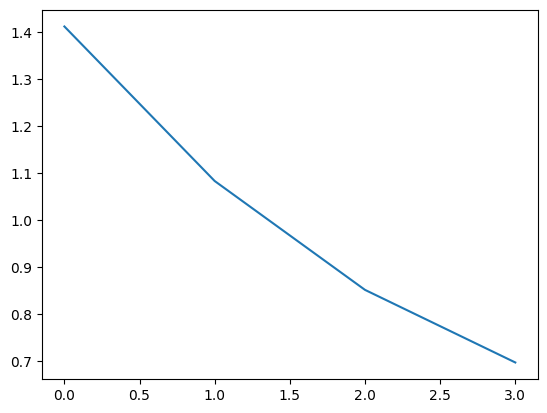

In [15]:
class CustomCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        if(epoch % EVAL_STEPS == EVAL_STEPS-1):
          # Evaluate
          display(HTML(inference_test(test_image)))
          make_predictions()

#history = pali_gemma_lm.fit(train_data, epochs=TRAIN_STEPS, callbacks=[CustomCallback()])
history = pali_gemma_lm.fit(train_data, epochs=TRAIN_STEPS)
plt.plot(history.history['loss'])
plt.show()

We have taken only 3b model also with a small dataset. If you have more compute u can take more parameter model and with more data.
The process remains same

## Inference After fine tuning


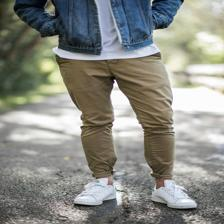


Inference Result



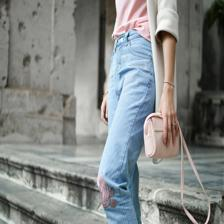
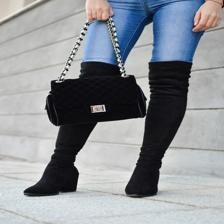
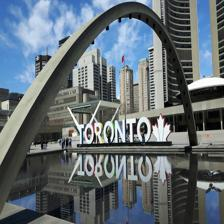
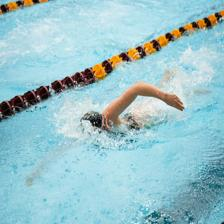

In [17]:
display(HTML(inference_test(test_image)))
make_predictions()